# IMDB Sentiment prediction
## 1. Setup


In [1]:
import re
from collections import Counter
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import defaultdict
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import string
import stopwords
import nltk
from nltk import pos_tag, word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers


nltk.download("punkt")
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("averaged_perceptron_tagger")

[nltk_data] Downloading package punkt to /home/mateusz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/mateusz/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/mateusz/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/mateusz/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
df =  pd.read_csv("./IMDB_Dataset.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [3]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [4]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
df["sentiment"] = df["sentiment"].map({"positive": 1, "negative":0})
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


## 2. Cleanup
### 2.1 HTML

In [6]:
def remove_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    text_without_tags = soup.get_text(separator=' ')
    return text_without_tags

df["review"] = df["review"].apply(lambda x: remove_html_tags(x))
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. The filming te...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


### 2.2 Removing contractions

In [7]:
def remove_contractions(text):
    # This solution is copied from an answer to a stackoverflow question:
    # https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python

    # specific
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)

    # general
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

df["review"] = df["review"].apply(lambda x: remove_contractions(x))
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. The filming te...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there is a family where a little boy...,0
4,"Petter Mattei is ""Love in the Time of Money"" i...",1


### 2.3 Punctuation

In [8]:
def remove_punctuation(text):
    text_list_without_punctuation = [letter for letter in text if letter not in string.punctuation]
    text_without_punctuation = ''.join(text_list_without_punctuation)
    return text_without_punctuation

df["review"] = df["review"].apply(lambda x: remove_punctuation(x))
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production The filming tec...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there is a family where a little boy...,0
4,Petter Mattei is Love in the Time of Money is ...,1


### 2.4 Whitespaces

In [9]:
def remove_whitespace(text):
    pattern = re.compile(r'\s+')
    text_without_whitespace = re.sub(pattern, ' ', text)
    return text_without_whitespace

df["review"] = df["review"].apply(lambda x: remove_whitespace(x))
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production The filming tech...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there is a family where a little boy...,0
4,Petter Mattei is Love in the Time of Money is ...,1


### 2.5 Lowercase

In [10]:
def text_to_lower(text):
    return text.lower()

df["review"] = df["review"].apply(lambda x: text_to_lower(x))
df.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production the filming tech...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically there is a family where a little boy...,0
4,petter mattei is love in the time of money is ...,1


### 2.6 Stopwords

In [11]:
stoplist = stopwords.get_stopwords("english")
stoplist = set(stoplist)

def remove_stopwords(text):
    no_stopwords_list = [word for word in word_tokenize(text) if word not in stoplist]
    no_stopwords_text = " ".join(no_stopwords_list)
    return no_stopwords_text

df["review"] = df["review"].apply(lambda x: remove_stopwords(x))
df.head()

,review,sentiment
0,one reviewers mentioned watching just 1 oz epi...,1
1,wonderful little production filming technique ...,1
2,thought wonderful way spend time hot summer we...,1
3,basically family little boy jake thinks zombie...,0
4,petter mattei love time money visually stunnin...,1


### 2.7 Lemmatization

In [12]:
tag_map = defaultdict(lambda : wordnet.NOUN)
tag_map['J'] = wordnet.ADJ
tag_map['V'] = wordnet.VERB
tag_map['R'] = wordnet.ADV

def lemmatize(text):
    tokens = word_tokenize(text)
    lemmatized_tokens = []
    lemmatizer = WordNetLemmatizer()
    for token, tag in pos_tag(tokens):
        lemmatized_token = lemmatizer.lemmatize(token, tag_map[tag[0]])
        lemmatized_tokens.append(lemmatized_token)
    return ' '.join(lemmatized_tokens)

df["review"] = df["review"].apply(lambda x: lemmatize(x))
df.head()

,review,sentiment
0,one reviewer mention watch just 1 oz episode w...,1
1,wonderful little production film technique una...,1
2,think wonderful way spend time hot summer week...,1
3,basically family little boy jake think zombie ...,0
4,petter mattei love time money visually stunnin...,1


## 3. Visualization

In [13]:
sentences = df["review"]
positive_reviews = ' '.join(sentences[df["sentiment"] == 1])
negative_reviews = ' '.join(sentences[df["sentiment"] == 0])
positive_wordcloud = WordCloud(width=800, height=800, background_color="black",
                               min_font_size=12).generate(positive_reviews)

negative_wordcloud = WordCloud(width=800, height=800, background_color="black",
                               min_font_size=12).generate(negative_reviews)

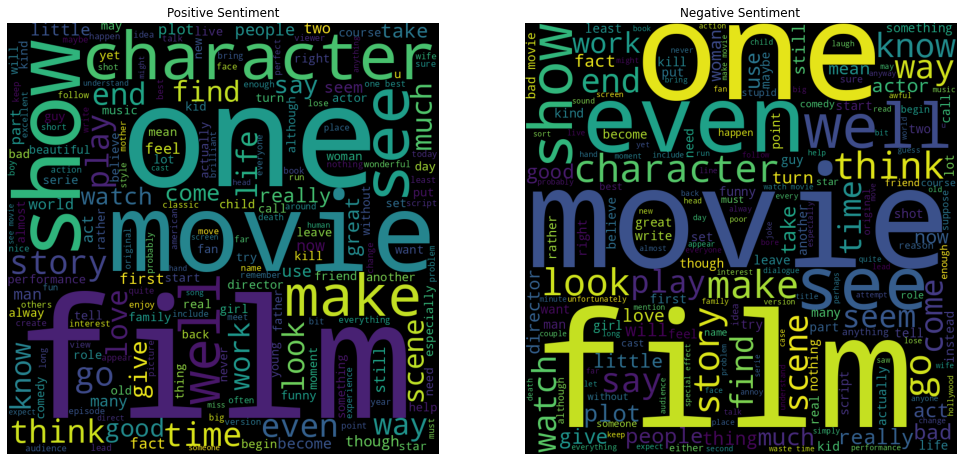

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(17, 8))
ax[0].imshow(positive_wordcloud)
ax[0].set_title("Positive Sentiment")
ax[0].axis("off")
ax[1].imshow(negative_wordcloud)
ax[1].set_title("Negative Sentiment")
ax[1].axis("off");

Text(0.5, 1.0, 'Top 20 negative words')

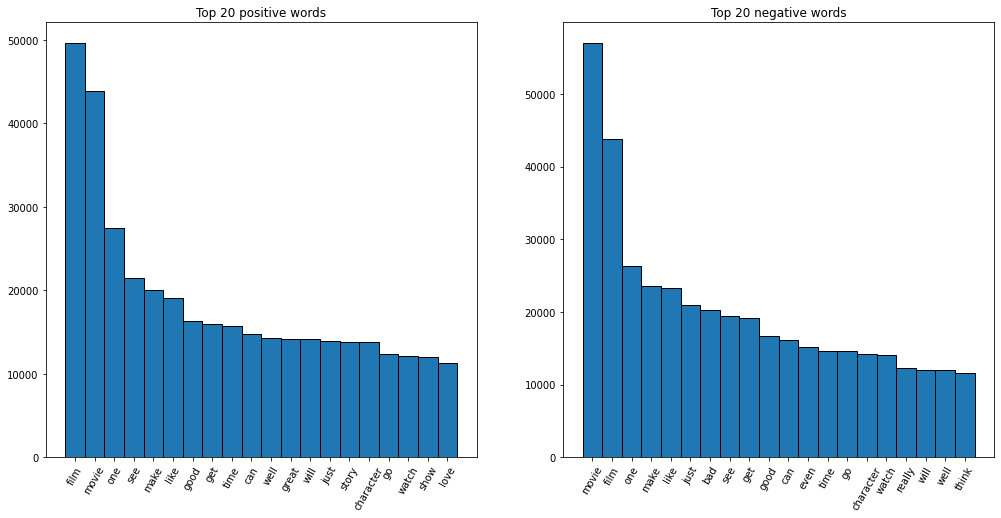

In [15]:
negative_words_counter = Counter(negative_reviews.split()).most_common()
neg_labels, neg_counts = zip(*negative_words_counter)


positive_words_counter = Counter(positive_reviews.split()).most_common()
pos_labels, pos_counts = zip(*positive_words_counter)
limit = 20
width = 1
indexes = np.arange(limit)

_, ax = plt.subplots(1, 2, figsize=(17,8))
# positive
ax[0].bar(indexes, pos_counts[:limit], width, align="edge", edgecolor="black")
ax[0].set_xticks(indexes + width * 0.5, pos_labels[:limit], rotation=60)
ax[0].set_title("Top 20 positive words")
# negative
ax[1].bar(indexes, neg_counts[:limit], width, align="edge", edgecolor="black")
ax[1].set_xticks(indexes + width * 0.5, neg_labels[:limit], rotation=60)
ax[1].set_title("Top 20 negative words")


## 4. Processing
### 4.1 Tokenization

In [16]:
all_reviews = positive_reviews + negative_reviews
words = all_reviews.split()
count_words = Counter(words)
total_words = len(words)
sorted_words = count_words.most_common(total_words)

sorted_words

[('movie', 100913),
 ('film', 93396),
 ('one', 53807),
 ('make', 43695),
 ('like', 42437),
 ('see', 40979),
 ('get', 35149),
 ('just', 34875),
 ('good', 33000),
 ('can', 30932),
 ('time', 30401),
 ('character', 27983),
 ('go', 27011),
 ('well', 26291),
 ('watch', 26244),
 ('will', 26196),
 ('even', 24918),
 ('story', 24670),
 ('bad', 24654),
 ('really', 23005),
 ('think', 22340),
 ('show', 21538),
 ('scene', 20647),
 ('great', 19801),
 ('look', 19226),
 ('say', 19133),
 ('much', 19109),
 ('end', 18509),
 ('people', 18226),
 ('know', 18186),
 ('also', 17857),
 ('give', 17300),
 ('first', 17212),
 ('take', 17174),
 ('way', 16925),
 ('love', 16624),
 ('thing', 16349),
 ('come', 16313),
 ('play', 16173),
 ('act', 16111),
 ('find', 15545),
 ('seem', 14059),
 ('many', 13390),
 ('life', 13340),
 ('work', 13279),
 ('plot', 13244),
 ('actor', 13157),
 ('two', 13082),
 ('never', 12881),
 ('want', 12870),
 ('best', 12454),
 ('little', 12361),
 ('year', 12354),
 ('try', 12075),
 ('ever', 11748),
 

In [17]:
vocab_to_int = {word: i + 1 for i, (word, _) in enumerate(sorted_words)}
print(f"There are {len(vocab_to_int)} words in the dict\n", vocab_to_int)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [18]:
df["review"] = df["review"].apply(lambda x: [vocab_to_int[word] for word in x.split()])
df.head()

,review,sentiment
0,"[3, 983, 318, 15, 8, 373, 2823, 187, 16, 1723,...",1
1,"[295, 52, 238, 2, 1487, 14774, 63320, 1083, 32...",1
2,"[21, 295, 35, 479, 11, 737, 1223, 2038, 347, 6...",1
3,"[550, 123, 52, 241, 2852, 21, 520, 3159, 551, ...",0
4,"[63322, 9139, 36, 11, 194, 1789, 3405, 2, 15, ...",1


<AxesSubplot:>

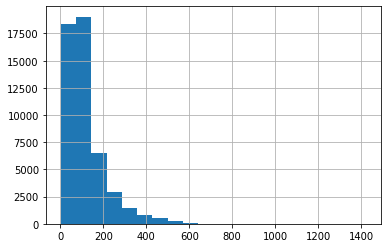

In [19]:
reviews_len = pd.Series([len(review) for review in df["review"]])
reviews_len.hist(bins=20)

In [20]:
reviews_len.describe()

count    50000.000000
mean       119.103880
std         89.743409
min          3.000000
25%         64.000000
50%         89.000000
75%        145.000000
max       1420.000000
dtype: float64

In [21]:
reviews_len[reviews_len > 600]

556       626
1531      719
3024      939
3654      809
5708      931
7899      776
8220      633
10363     618
12647     933
14562     707
14797     688
15890     626
18594     731
26582     779
27326     667
28525     629
29425     607
29676     618
31240    1130
31436    1169
31481    1420
32592     665
39874     617
40521    1101
42946     894
43821     804
47478     606
49772     619
dtype: int64

In [22]:
def pad_features(review, seq_length):
    if len(review) <= seq_length:
        zeros = list(np.zeros(seq_length - len(review)))
        new_features = review + zeros
    else:
        new_features = review[:seq_length]

    return new_features

df["review"] = df["review"].apply(lambda x: pad_features(x, 600))

## 5. Model
### 5.1 Splitting Data

In [42]:
X = df["review"].tolist()
y = df["sentiment"].tolist()

test_size = 0.2
validation_set_length = int(test_size / 2 * df.shape[0])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

X_validate = X_test[:validation_set_length]
y_validate = y_test[:validation_set_length]

X_test = X_test[validation_set_length:]
y_test = y_test[validation_set_length:]

X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

X_validate = np.array(X_validate)
y_validate = np.array(y_validate)

In [43]:
y_train.shape

(40000,)

### 5.2 Model

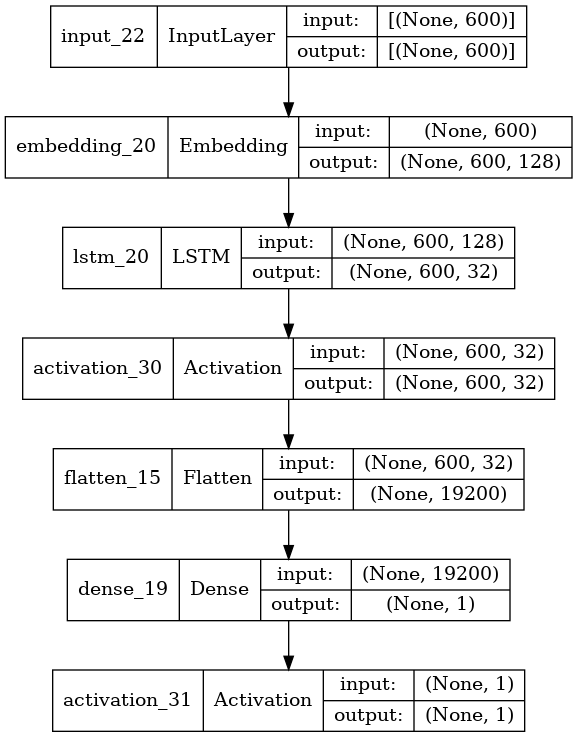

In [79]:
def make_model(input_shape):
    inputs = keras.Input(shape=input_shape)
    x = layers.Embedding(160000, 128)(inputs)
    x = layers.LSTM(32, dropout=0.2, return_sequences=True)(x)
    x = layers.Activation("relu")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1)(x)
    outputs = layers.Activation("sigmoid")(x)

    return keras.Model(inputs, outputs)

own_model = make_model(input_shape=600)
keras.utils.plot_model(own_model, show_shapes=True)

In [84]:
def train_model(model, epochs, batch_size):
    callbacks = [
              keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=epochs // 5,
                                            verbose=1,
                                            min_delta=0.01,
                                           restore_best_weights=True)
       ]

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )

    return model.fit(
        x=X_train,
        y=y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_validate, y_validate),
        callbacks=callbacks,
    )

In [46]:
def plot_model_performance(history):
       loss = history.history['loss']
       accuracy = history.history['accuracy']
       val_loss = history.history['val_loss']
       val_accuracy = history.history['val_accuracy']
       x_axis = [i for i in range(len(loss))]


       _, sub = plt.subplots(1, 2)
       sub[0].plot(x_axis, loss, 'y', label="Training loss")
       sub[0].plot(x_axis, val_loss, 'b', label="Validation loss")
       sub[0].set_title("Training and validation loss")
       sub[0].set_xlabel("Epochs")
       sub[0].set_ylabel("Loss")
       sub[0].legend()

       sub[1].plot(x_axis, accuracy, 'y', label="Training accuracy")
       sub[1].plot(x_axis, val_accuracy, 'b', label="Validation accuracy")
       sub[1].set_title("Training and validation accuracy")
       sub[1].set_xlabel("Epochs")
       sub[1].set_ylabel("Loss")

In [85]:
own_history = train_model(own_model, 40, 128)

Epoch 1/40
313/313 [==============================] - 11s 33ms/step - loss: 0.0044 - accuracy: 0.9987 - val_loss: 1.0821 - val_accuracy: 0.8764
Epoch 2/40
313/313 [==============================] - 10s 33ms/step - loss: 0.0033 - accuracy: 0.9988 - val_loss: 1.1044 - val_accuracy: 0.8710
Epoch 3/40
313/313 [==============================] - 10s 32ms/step - loss: 0.0054 - accuracy: 0.9985 - val_loss: 1.1819 - val_accuracy: 0.8796
Epoch 4/40
313/313 [==============================] - 10s 33ms/step - loss: 0.0067 - accuracy: 0.9980 - val_loss: 0.9422 - val_accuracy: 0.8748
Epoch 5/40
313/313 [==============================] - 10s 33ms/step - loss: 0.0022 - accuracy: 0.9995 - val_loss: 0.9732 - val_accuracy: 0.8784
Epoch 6/40
313/313 [==============================] - 10s 32ms/step - loss: 0.0013 - accuracy: 0.9996 - val_loss: 1.1171 - val_accuracy: 0.8792
Epoch 7/40
313/313 [==============================] - 10s 32ms/step - loss: 0.0011 - accuracy: 0.9996 - val_loss: 1.1473 - val_accuracy:

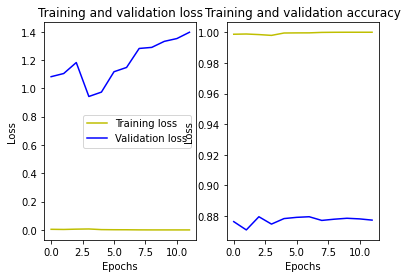

In [86]:
plot_model_performance(own_history)

In [68]:
own_model.evaluate(X_test, y_test)

157/157 [==============================] - 1s 9ms/step - loss: 0.6015 - accuracy: 0.8584


[0.6014865040779114, 0.8583999872207642]